# Benchmark: Manns Lab Patient Dataset

In this notebook, we will explore a human patient dataset. Brain tissue from each patient has been extracted, and proteins in each tissue have been identified and intensities quantified.
We have access to two datasets, "PILOT" and "MAIN". PILOT contains a subset of the patients in MAIN. PILOT has fewer missing intensities than MAIN. Thus, we'll use PILOT as the validation set and MAIN as the training set.

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import data_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s define the paths.

In [8]:
MAIN_DIR = "../../data/manns_lab/MAIN/"
PILOT_DIR = "../../data/manns_lab/PILOT/"

Let"s load the data.

In [9]:
adata = sup.load_data(MAIN_DIR, PILOT_DIR, do_batch_correction=True, integrate=True)

preprocess input: (4566, 2703)
sc.pp.filter_genes: (4566, 2703)
sc.pp.filter_cells: (4566, 2703)
filter: (4566, 2018)
preprocess input: (454, 3306)
sc.pp.filter_genes: (454, 3305)
sc.pp.filter_cells: (454, 3305)
filter: (454, 2963)


/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/notebooks/manns_lab_data/data_support.py:312: RuntimeWarning: Mean of empty slice
  mean_protein_per_plate = np.nanmean(x, axis=0)


transfering 447 cells and 1783 proteins during reshape.

main intensity coverage:     69.66%
pilot intensity coverage:    7.47%
combined intensity coverage: 71.28%


## PROTVI

### Training

Let's now train the model.

In [10]:
adata.X = adata.layers["main"].copy()
adata.X[np.isnan(adata.X)] = 0

In [22]:
PROTVI.setup_anndata(adata, batch_key="Plate") #, continuous_covariate_keys=["log Qalb"])

model = PROTVI(adata, log_variational=False, decoder_type="selection")
#model.view_anndata_setup()

Let's train the model.

In [ ]:
model.train(max_epochs=3000, plan_kwargs={"mechanism_weight": 1}, check_val_every_n_epoch=1) #, plan_kwargs={"min_kl_weight": 8, "max_kl_weight": 8})

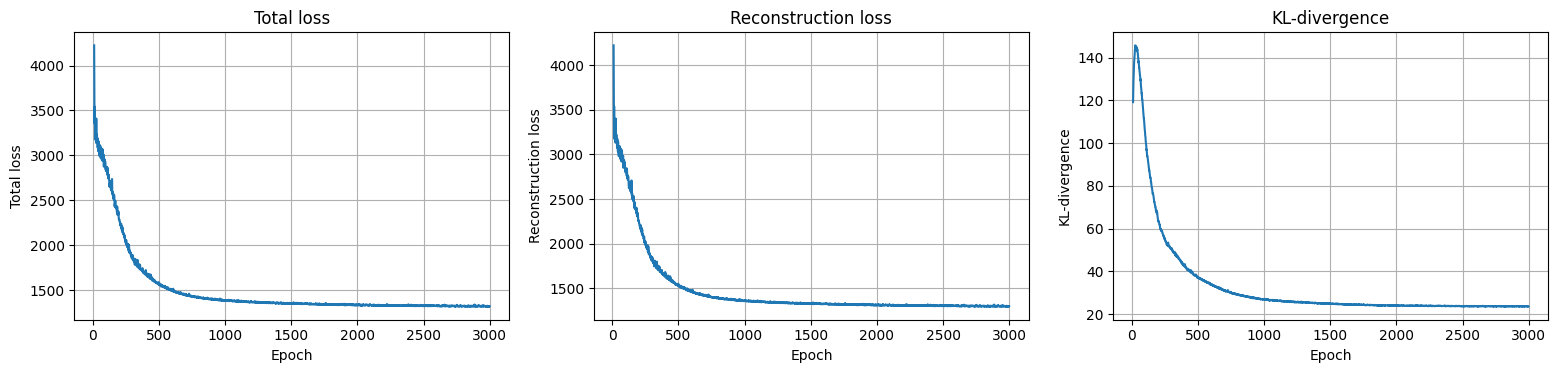

In [13]:
pl.plot_loss(model.history, epoch_start=10)

### Evaluation on training set (MAIN)

In [14]:
x_est, p_est = model.impute()

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

Let's compute compute some common performance metrics to compare with other models later.

In [15]:
common_metrics = sup.compute_common_metrics(x_main, x_pilot, x_est)
sup.save_dict_to_results(common_metrics, "protvi selection.pkl")

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

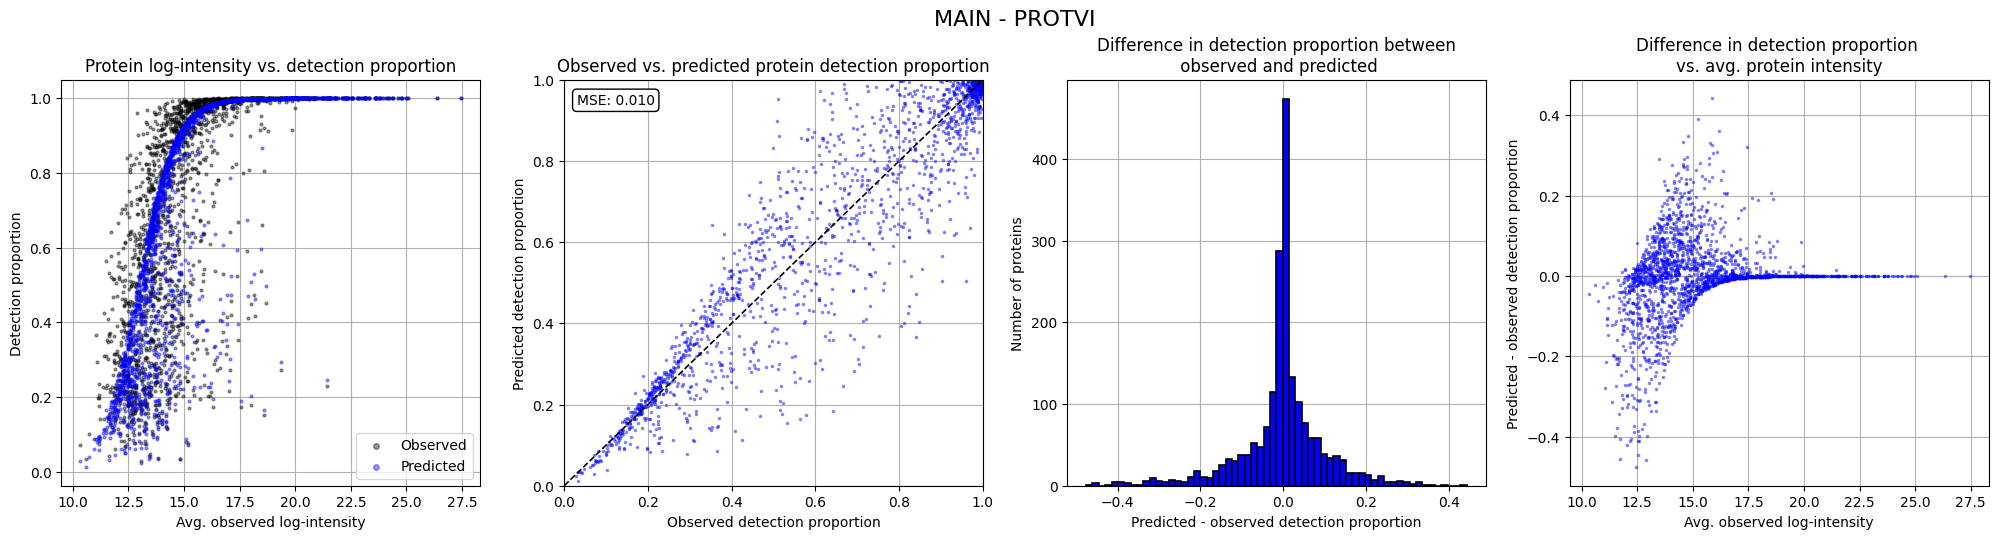

In [16]:
pl.plot_protein_detection_proportion_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

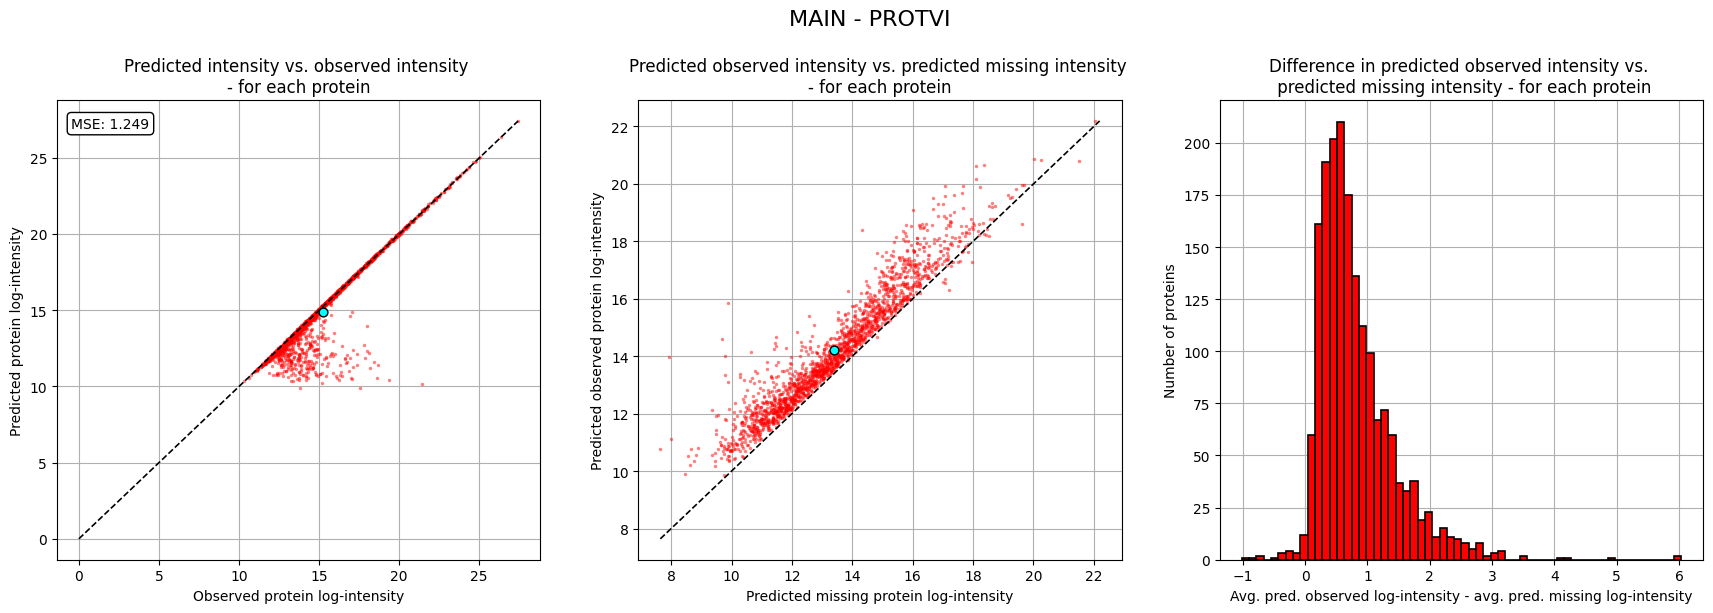

In [17]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

Let's look at the latent space.

In [25]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

2023-11-15 23:54:15.436925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 23:54:15.436950: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 23:54:15.436967: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 23:54:16.208552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


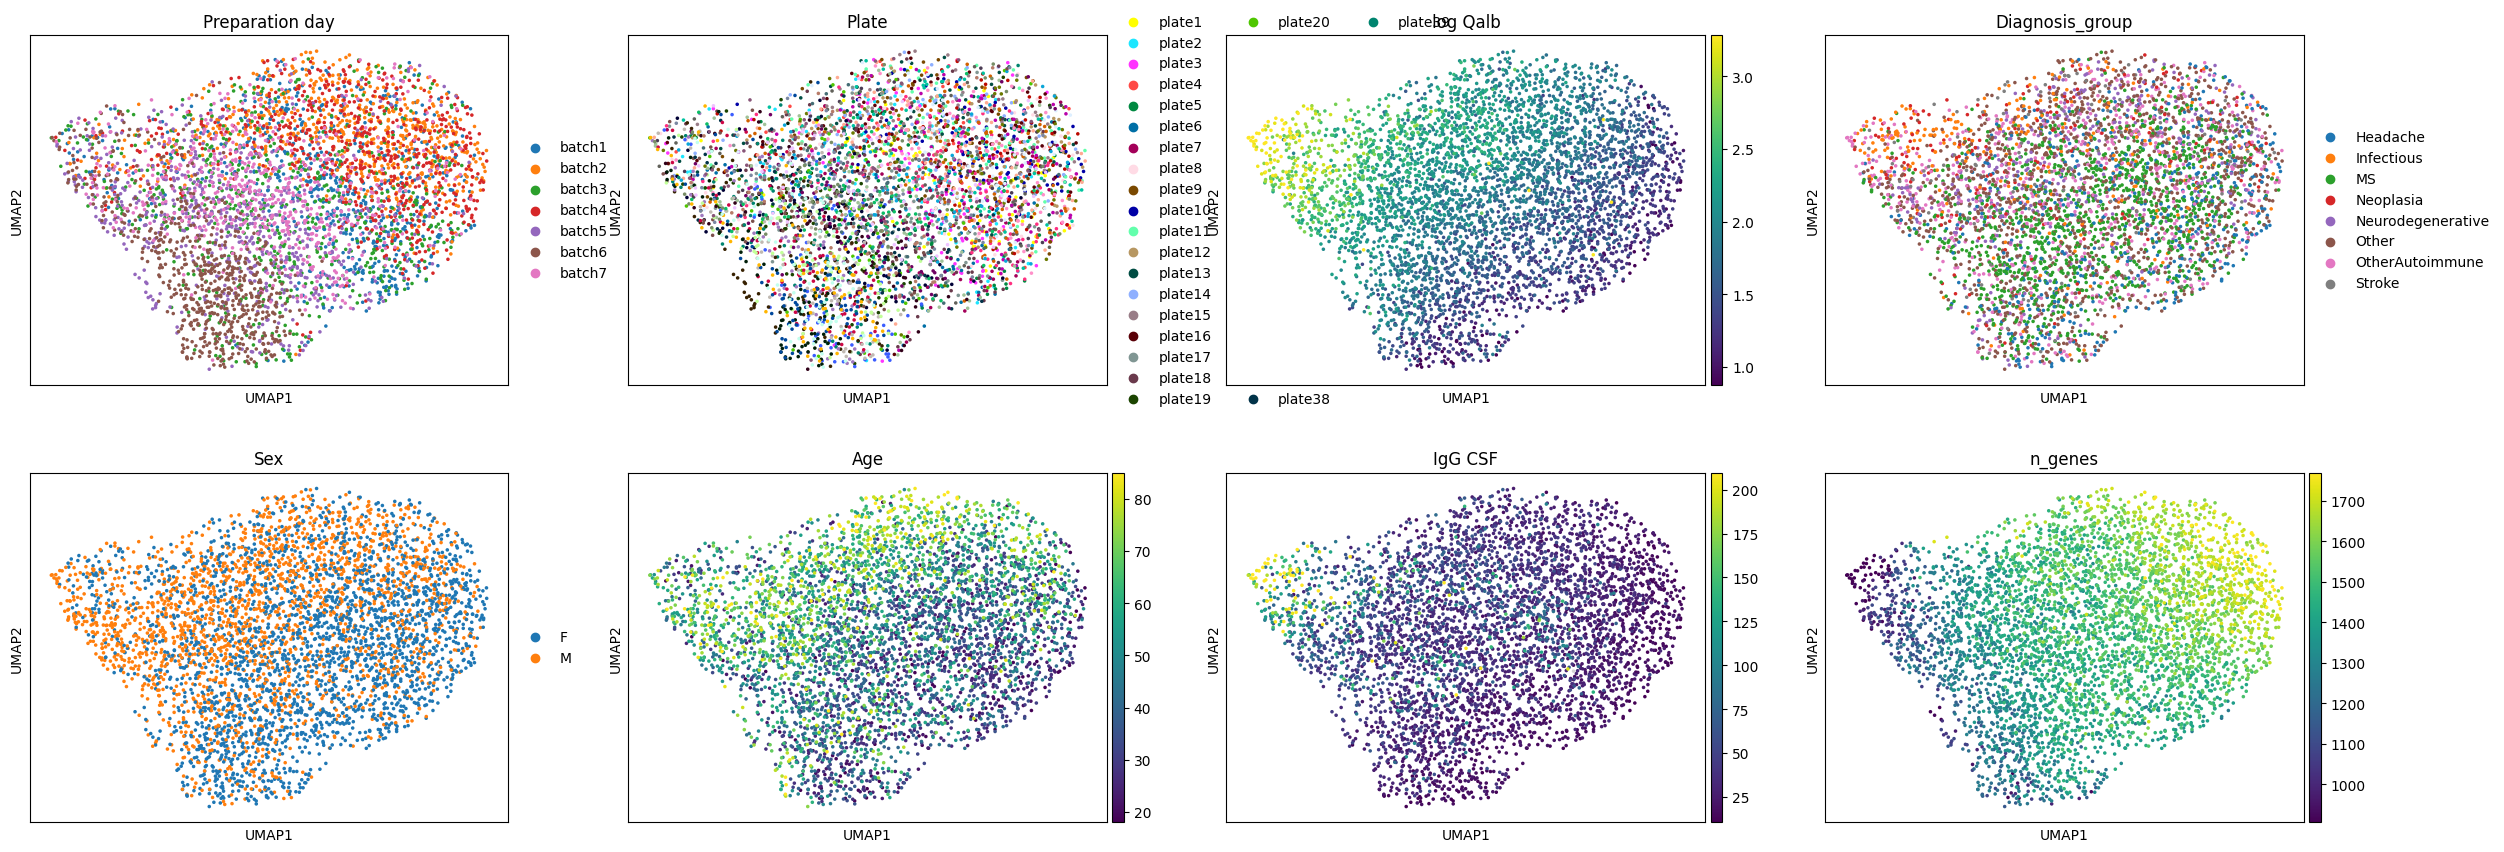

In [ ]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Preparation day", "Plate", "log Qalb", "Diagnosis_group", "Sex", "Age", "IgG CSF", "n_genes"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

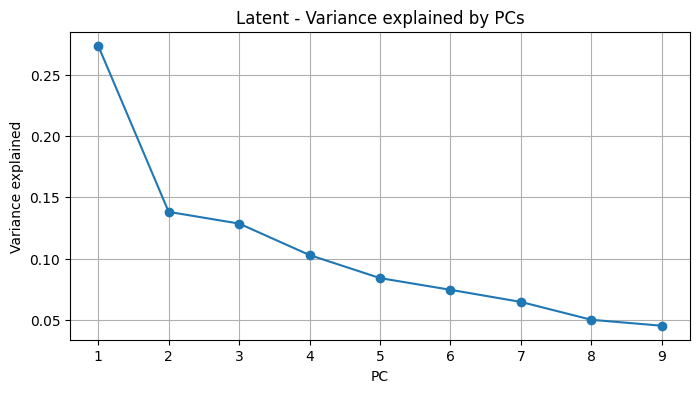

In [ ]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the patient means and variances.

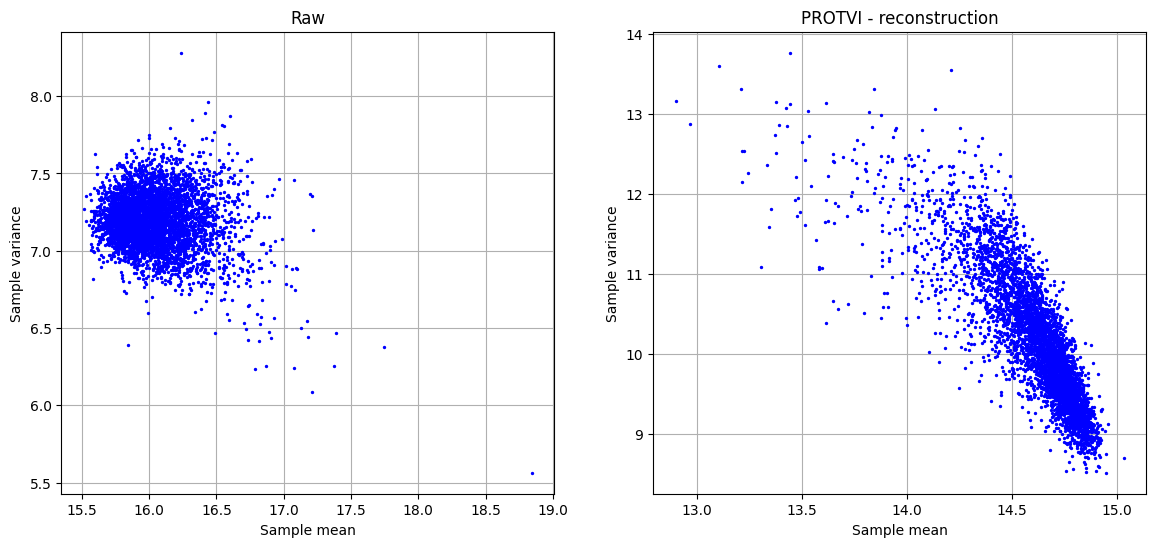

In [ ]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["main"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

### Evaluation on validation set (PILOT)

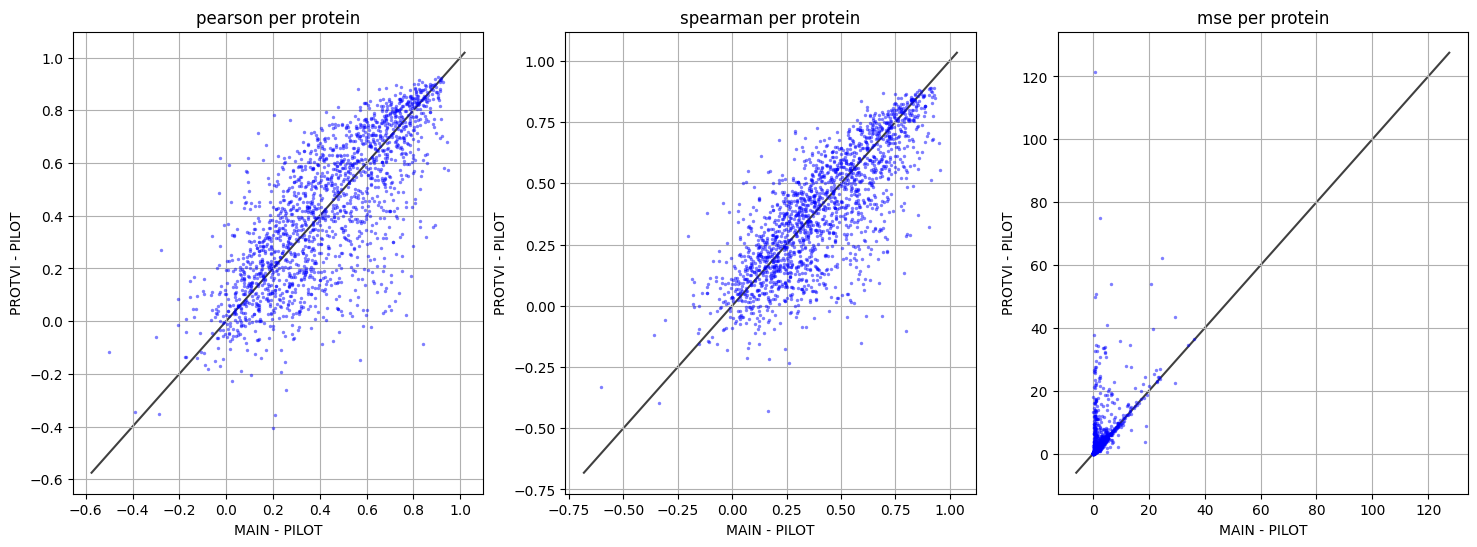

In [ ]:
sup.scatter_main_pilot_model(adata.layers["main"], adata.layers["pilot"], x_est, n_min_protein_overlap=2)

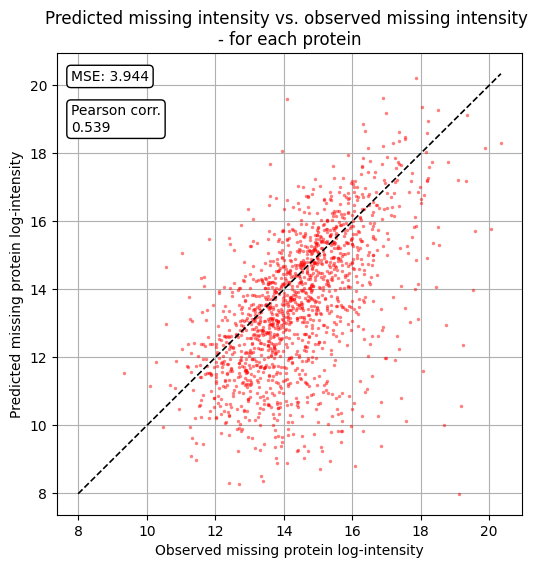

In [ ]:
sup.scatter_pilot_model_protein(adata.layers["main"], adata.layers["pilot"], x_est)

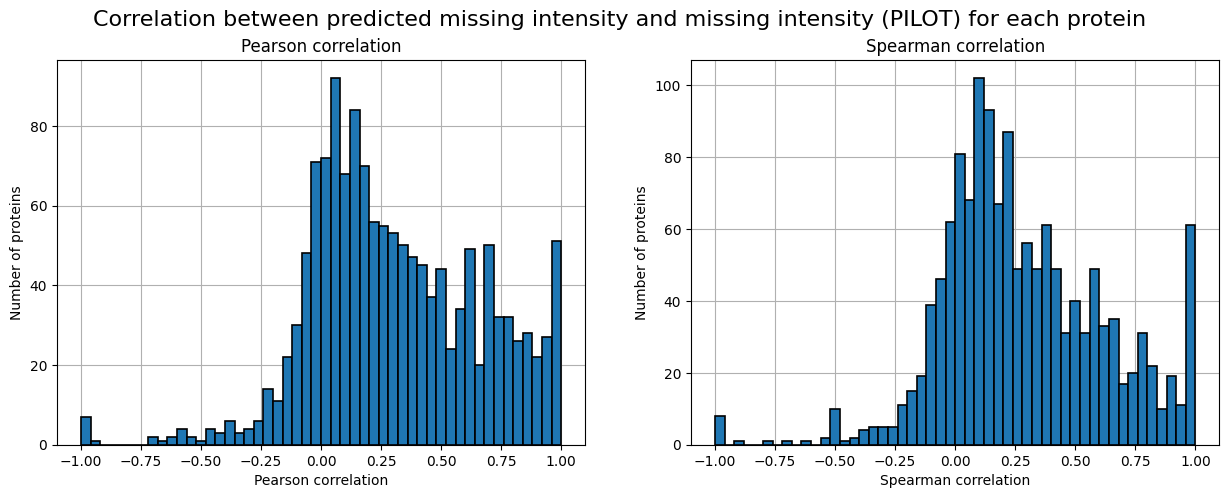

In [ ]:
x_pilot = adata.layers["pilot"]

corrs = metrics.compare_intensities_protein_wise(x_est_miss, x_pilot)

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("Correlation between predicted missing intensity and missing intensity (PILOT) for each protein", fontsize=16)

ax = axes[0]
ax.hist(corrs["pearson"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(corrs["spearman"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

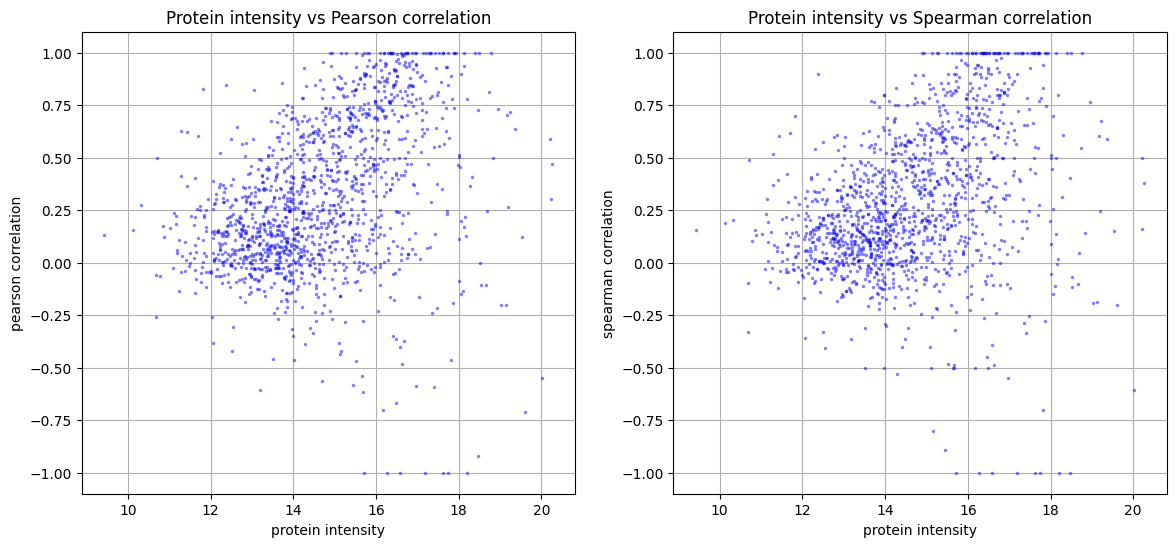

In [ ]:
overlap_mask = ~np.isnan(x_est_miss) & ~np.isnan(x_pilot)
idx_proteins = np.where(overlap_mask.sum(axis=0) >= 2)[0]
x_overlap = np.nanmean(x_pilot[:, idx_proteins], axis=0)

fig, axes = plt.subplots(figsize=(14, 6), ncols=2)

ax = axes[0]
ax.scatter(x_overlap, corrs["pearson"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs Pearson correlation")
ax.set_xlabel("protein intensity")
ax.set_ylabel("pearson correlation")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(x_overlap, corrs["spearman"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs Spearman correlation")
ax.set_xlabel("protein intensity")
ax.set_ylabel("spearman correlation")
ax.grid(True)
ax.set_axisbelow(True)

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [ ]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
r_adata = utils.prepare_anndata_for_R(adata)

In [ ]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "main")
dpcfit <- dpc(X)

In [ ]:
protdp_result = robjects.r("dpcfit")

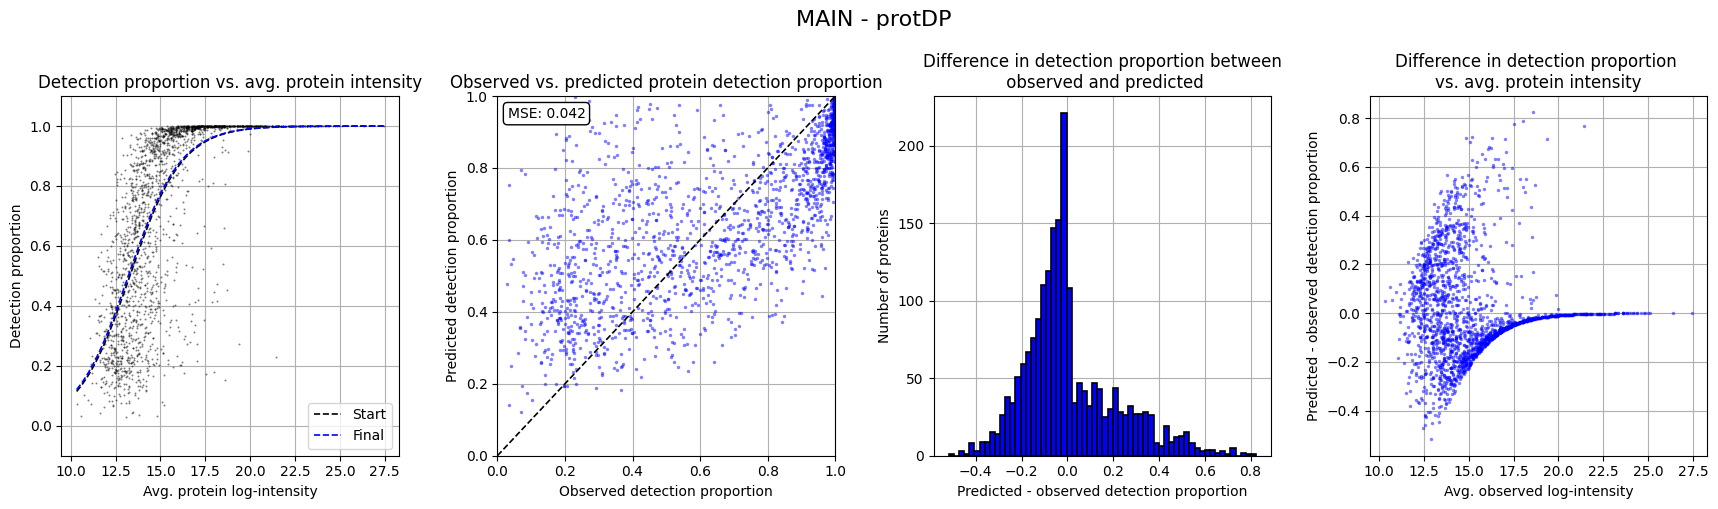

In [ ]:
pl.plot_protein_detection_proportion_panel_protDP(x_main, protdp_result, title="MAIN - protDP")

In [ ]:
common_metrics = sup.compute_common_metrics_protDP(x_main, x_pilot, protdp_result["mu_obs"], protdp_result["mu_mis"])
sup.save_dict_to_results(common_metrics, "protDP.pkl")

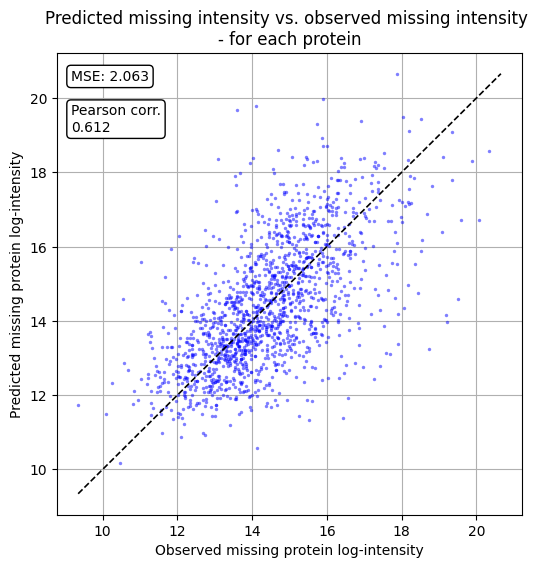

In [ ]:
miss_mask = np.logical_and(np.isnan(x_main), ~np.isnan(x_pilot))
protein_mask = miss_mask.any(axis=0)

x_pilot_sub = x_pilot.copy()
x_pilot_sub[~miss_mask] = np.nan
x_pilot_sub = x_pilot_sub[:, protein_mask]

x_est_protein = protdp_result["mu_mis"][protein_mask]
x_pilot_protein = np.nanmean(x_pilot_sub, axis=0)

pl.scatter_compare_protein_missing_intensity(x_pilot_protein, x_est_protein, color="blue")

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_23396/2969831900.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


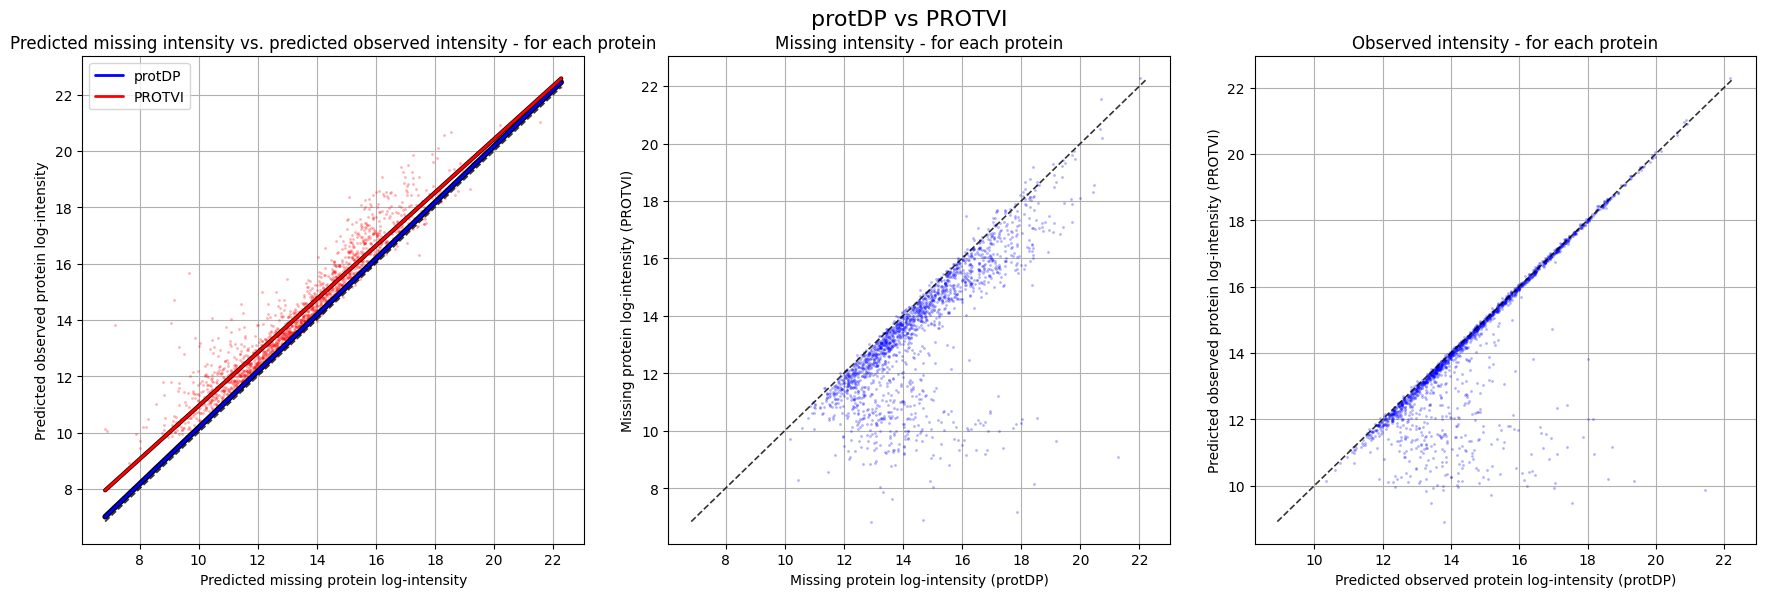

In [ ]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_main, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

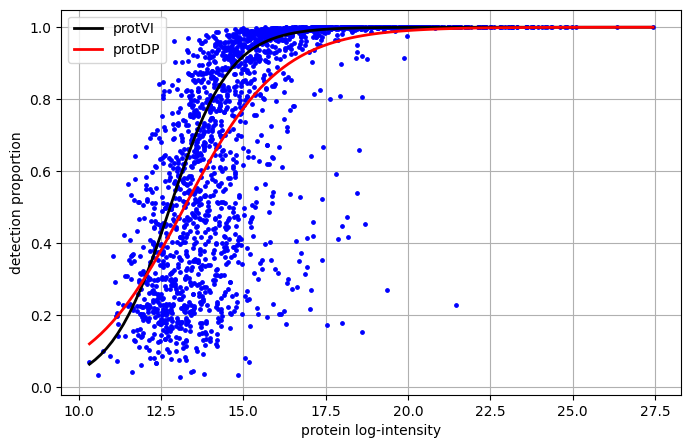

In [ ]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_main, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_main), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_main, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compare_detection_proportion_curves(x, curves, fig=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x, ax=ax)

    x_protein = np.nanmean(x, axis=0)

    for name, curve in curves.items():
        intercept, slope = curve
        xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
        ys = sigmoid(slope * xs + intercept)
        ax.plot(xs, ys, label=name, linewidth=2)

    ax.legend()

In [ ]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

curves = {
    "protVI": (intercept, slope),
    "protDP": protdp_result["beta"],
}

compare_detection_proportion_curves(x_main, curves)